# Arbitrary Style Transfer with Adaptive Instance Normalization

dated: 3 Feb 2023

Paolo Zinesi

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange

In [2]:
torch.manual_seed(17)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# I/O -----------------------------

STYLE_IMAGE_FILE = "./image/starry_night.jpg"
#STYLE_IMAGE_FILE = "./image/picasso.jpg"
#STYLE_IMAGE_FILE = "./image/the_scream.jpg"

CONTENT_IMAGE_FILE = "./image/tuebingen.jpg"
#CONTENT_IMAGE_FILE = "./image/golden_gate.jpg"
#CONTENT_IMAGE_FILE = "./image/dancing.jpg"

## Model definition

In [5]:
class AdaIN(nn.Module):
    """ Implementation of Adaptive Instance Normalization (AdaIN) layer as described in the paper."""

    def __init__(self, eps=1e-5):
        super().__init__()

        self.eps = eps
    

    def forward(self, x, y):
        """ Inputs:
                - x: content input of size (N,C,H,W) or (C,H,W)
                - y: style input of size (N,C,H,W) or (C,H,W)
            Output:
                - x_scaled: scaled content such that it matches channel-wise mean and variances of the style
        """

        # transform x to a 4-dim tensor
        if x.dim() == 3:
            content = torch.unsqueeze(x, 0)
        elif x.dim() == 4:
            content = x
        else:
            content = None

        # transform y to a 4-dim tensor
        if y.dim() == 3:
            style = torch.unsqueeze(y, 0)
        elif y.dim() == 4:
            style = y
        else:
            style = None
        
        # means and stds with sizes = (N,C,1,1)
        style_mean = torch.mean(style, dim=[2,3], keepdim=True)
        style_std = torch.std(style, dim=[2,3], keepdim=True) + self.eps
        content_mean = torch.mean(content, dim=[2,3], keepdim=True)
        content_std = torch.std(content, dim=[2,3], keepdim=True) + self.eps

        # result
        AdaIN_x_y = style_std * ((content - content_mean)/content_std) + style_mean

        return AdaIN_x_y

In [6]:
class VGG_Encoder_network(nn.Module):
    """ Network that encodes on the first layers of a VGG-19 network content and style images.
        This network is shallower than the VGG-19.
        This implementation is identical to the network used for NST (of Gatys)."""

    def __init__(self, input_model, forward_hooks:list,
                 pool:str = 'max',  crop_model:bool = True
                ):
        super().__init__()

        # -----------------------------
        #       HOOKS MANAGEMENT
        # -----------------------------
        self.hooks, self.hook_handlers = {}, []
        def takeOutput(name:str):
            def hook(model, input, output):
                self.hooks[name] = output #.detach()
                # note: DO NOT DETACH! I WILL NEED GRADIENTS LATER
            return hook
        #
        #  self.hook_handlers     will store the handlers of
        #                         fwd hooks I will register
        #  self.hooks             will store the values taken with hooks
        #                         from selected layers

        self.hooks_init = forward_hooks.copy()  # keep a backup copy of this arg
        todo_hooks = set(forward_hooks)         # will use this list while I loop on network layers


        # --------------------------------------
        #              MODEL BUILD
        # --------------------------------------
        #   I loop over the input model layers,
        #  registering a hook when requested.
        #   Only the first layers are saved.
        # --------------------------------------
        self.model = nn.Sequential()
        

        conv_num, conv_group = 1, 1
        for layer in input_model.children():
            
            if isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(conv_group, conv_num)
            
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(conv_group, conv_num)
                #  ^^  takes the name similar to last conv layer
                conv_num += 1

            elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d) ):
                # take name & reset counters
                name = 'pool_{}'.format(conv_group)
                conv_group += 1;   conv_num = 1; 

                # replace pool layer with desired choice
                if   pool.lower() == 'avg':
                    layer = nn.AvgPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                elif pool.lower() == 'max':
                    layer = nn.MaxPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                else:
                    raise RuntimeError('not valid pool arg ({})'.format(pool))

            else: name = 'buh'
            
            self.model.add_module(name, layer)
        

            if name in todo_hooks:
                # register a hook for current layer and track its handler
                self.hook_handlers.append(
                    self.model[-1].register_forward_hook( takeOutput(name) )
                )
                todo_hooks.remove(name)

            if crop_model:
                if not todo_hooks: break
                
        
        # fix the weights, to be sure
        for param in self.model.parameters():
            param.requires_grad = False

        # set to eval mode
        self.model.eval()


    def forward(self, x, query : list = None):
        
        if np.any(np.array(x.shape[-2:]) % 2**3 != 0):
            print("Required shapes multiple of 8!")
            return None

        self.hooks = {}     # reset hooks dict

        encoded_x = self.model(x)

        # returns the encoded features and the features extracted by hooks
        if query is not None:
            return (encoded_x, [ self.hooks[key] for key in query ])
            # this is a (torch.Tensor, list)
        else:
            return (encoded_x, self.hooks)
            # this is a (torch.Tensor, dict)

In [7]:
class VGG_Decoder_network(nn.Module):
    """ Network that decodes the AdaIN result 't' into the original image.
        This network has an architecture that is the mirrored version of the encoder, 
        it is shallower than the VGG-19 architecture and it needs to be trained.
    """

    def __init__(self, input_model, last_layer:str, forward_hooks:list,
                 pool:str = 'max',  #crop_model:bool = True
                ):
        super().__init__()

        # -----------------------------
        #       HOOKS MANAGEMENT
        # -----------------------------
        self.hooks, self.hook_handlers = {}, []
        def takeOutput(name:str):
            def hook(model, input, output):
                self.hooks[name] = output #.detach()
                # note: DO NOT DETACH! I WILL NEED GRADIENTS LATER
            return hook
        #
        #  self.hook_handlers     will store the handlers of
        #                         fwd hooks I will register
        #  self.hooks             will store the values taken with hooks
        #                         from selected layers

        self.hooks_init = forward_hooks.copy()  # keep a backup copy of this arg
        todo_hooks = set(forward_hooks)         # will use this list while I loop on network layers


        # --------------------------------------
        #              MODEL BUILD
        # --------------------------------------
        #   I loop over the input model layers,
        #  registering a hook when requested.
        # --------------------------------------
        #self.reversed_model = nn.Sequential()
        self.model = nn.Sequential()
        self.original_layers = []
        self.reversed_layers = []
        
        # loop to retrieve once all the shallow layers
        conv_num, conv_group = 1, 1
        for layer in input_model.children():
            
            if isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(conv_group, conv_num)
            
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(conv_group, conv_num)
                #  ^^  takes the name similar to last conv layer
                conv_num += 1

            elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d) ):
                # take name & reset counters
                name = 'pool_{}'.format(conv_group)
                conv_group += 1;   conv_num = 1; 

                # replace pool layer with desired choice
                if   pool.lower() == 'avg':
                    layer = nn.AvgPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                elif pool.lower() == 'max':
                    layer = nn.MaxPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                else:
                    raise RuntimeError('not valid pool arg ({})'.format(pool))

            else: name = 'buh'
            
            # add to the list to revert
            self.original_layers.append((name, layer))

            # when the final layer is reached, stop the inclusion of new layers
            if name == last_layer:
                break


        
        # loop to create the reversed layers (that will be reversed to obtain the correct decoder model)
        in_ch, out_ch = -1, -1
        for orig_name, orig_layer in self.original_layers:
            
            if "conv" in orig_name:
                # used to initialize the corresponding ConvTranspose2d module
                in_ch = orig_layer.out_channels
                out_ch = orig_layer.in_channels

                self.reversed_layers.append((orig_name.replace("conv", "relu"), nn.ReLU()))

            elif "relu" in orig_name:
                self.reversed_layers.append((orig_name.replace("relu", "conv"), nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=1, padding=2)))
                self.reversed_layers.append((orig_name.replace("relu", "reflpad"), nn.ReflectionPad2d(1)))
                
            elif "pool" in orig_name:
                self.reversed_layers.append((orig_name.replace("pool", "upscale"), nn.Upsample(scale_factor=2)))
            else:
                None
            

        # loop to build the correct decoder model
        for rev_name, rev_layer in reversed(self.reversed_layers):
            
            self.model.add_module(rev_name, rev_layer)

            if rev_name in todo_hooks:
                # register a hook for current layer and track its handler
                self.hook_handlers.append(
                    self.model[-1].register_forward_hook( takeOutput(rev_name) )
                )
                todo_hooks.remove(rev_name)




    def forward(self, x, query : list = None):

        self.hooks = {}     # reset hooks dict

        decoded_x = self.model(x)

        # returns the features extracted by hooks
        if query is not None:
            return (decoded_x, [ self.hooks[key] for key in query ])
            # this is a ...
        else:
            return (decoded_x, self.hooks)
            # this is a ...

### allocate the network

To do this I need the list of layer to hook from.

In [8]:
# content_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1']
# style_layers = ['relu1_2', 'relu2_2', 'relu3_2', 'relu4_2']

content_layers = ['relu4_1']
style_layers = ['relu4_2']

**Ref**: VGG19 doc
https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html

> Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.

In [9]:
# take the original VGG-19 model (pretrained weights)
vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')

# according to VGG199 documentation, the network uses these
# parameters for input normalization
vgg19_mean = np.array( [0.485, 0.456, 0.406] )
vgg19_std = np.array( [0.229, 0.224, 0.225] )


VGG_Encoder = VGG_Encoder_network(vgg19.features, content_layers)
VGG_Encoder.to(device);   # to suppress network layout print


VGG_Decoder = VGG_Decoder_network(vgg19.features, "relu4_2", style_layers)
VGG_Decoder.to(device);   # to suppress network layout print

## Image processing

In [10]:
class CropToMultiple(nn.Module):
    """ Custom crop transformation to a multiple of a given number.

    Args:
        factor (tuple or int): Desired factor of transformed type.
    """

    def __init__(self, factor):
        super().__init__()
        assert isinstance(factor, (int, tuple))
        if isinstance(factor, int):
            self.factor = (factor, factor)
        else:
            assert len(factor) == 2
            self.factor = factor

    def forward(self, img):

        w, h = img.size[-2:]
        new_h = self.factor[0] * (h // self.factor[0])
        new_w = self.factor[1] * (w // self.factor[1])

        return transforms.CenterCrop((new_h, new_w))(img)


In [11]:
# pre and post processing for images
img_size = 128
factor = 8 # enforce factorizability of the image shapes by 8

img_preprocess = transforms.Compose([
        transforms.Resize(img_size),
        CropToMultiple(factor),
        transforms.ToTensor(),
        transforms.Normalize(mean = vgg19_mean, std=vgg19_std),
        transforms.Lambda(lambda x: x.mul_(255)),
])

img_revert = transforms.Compose([
        transforms.Lambda(lambda x: x.mul_(1./255)),
        transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/vgg19_std),
        transforms.Normalize(mean = -vgg19_mean, std = [1,1,1]),
])

transf_toPIL = transforms.Compose([ transforms.ToPILImage() ])

def tens2pil( img_tensor ):
    img_tensor = img_tensor.clone().detach()
    # invert the input trasform
    x = img_revert(img_tensor)
    # removed burned areas
    t = torch.clamp( x, min=0, max=1)
    return transf_toPIL( torch.squeeze(t) )

In [12]:
def load_image(filename, preprocess = None, device = None, add_batch : bool = True):
    img = Image.open(filename)

    # optional: apply custom preprocess function, else use the default
    if preprocess: img = preprocess(img)
    else:          img = img_preprocess(img)

    # optional: send to device
    if device:     img = img.to(device)

    # optional: add dummy batch dimention
    if add_batch:  img = img.unsqueeze(0)
    
    return img


style_image = load_image(STYLE_IMAGE_FILE, device = device)
content_image = load_image(CONTENT_IMAGE_FILE, device = device)

#generated_img = content_image.clone()

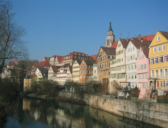

In [13]:
tens2pil(content_image)

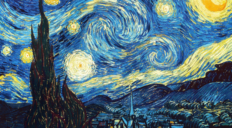

In [14]:
tens2pil(style_image)

## Test the AdaIN layer

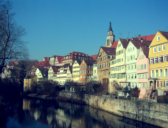

In [15]:
AdaIN_fn = AdaIN(eps=1e-6)

AdaIN_image = AdaIN_fn(content_image, style_image)
tens2pil(AdaIN_image)

# Test of Encoder-Decoder

In [16]:
print(content_image.shape)
print(style_image.shape)

torch.Size([1, 3, 128, 168])
torch.Size([1, 3, 128, 232])


In [17]:
enc_image, hooks_enc_image = VGG_Encoder(content_image)
enc_style, hooks_enc_style = VGG_Encoder(style_image)

print(enc_image.shape)
print(enc_style.shape)

torch.Size([1, 512, 16, 21])
torch.Size([1, 512, 16, 29])


In [18]:
AdaIN_enc_image = AdaIN_fn(enc_image, enc_style)
print(AdaIN_enc_image.shape)

torch.Size([1, 512, 16, 21])


In [19]:
dec_image, hooks_dec_image = VGG_Decoder(AdaIN_enc_image)
print(dec_image.shape)

torch.Size([1, 3, 128, 168])


In [20]:
tens2pil(dec_image) # decoded image now is random

Training

In [38]:
iter_max = 100
lr = 1e-04
style_importance = 1e5
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(VGG_Decoder.parameters(), lr=lr)

In [39]:
# run style transfer

losses = []
for i in trange(iter_max):

    optimizer.zero_grad()
    

    # # retrieve other images ...
    # content_image = ....
    # style_image = ....

    # compute features of (new) images (= f(c) and f(s))
    enc_image, hooks_enc_image = VGG_Encoder(content_image)
    enc_style, hooks_enc_style = VGG_Encoder(style_image)

    # compute target feature map (= t)
    target_feat_map = AdaIN_fn(enc_image, enc_style)

    # generate stylized image (= g(t))
    generated_img, hooks_generated_img = VGG_Decoder(target_feat_map)

    # features of the stylized image (=f(g(t)))
    enc_generated_img, hooks_enc_generated_img = VGG_Encoder(generated_img)

    # LOSSES
    loss_style = 0
    for ii, jj in zip(style_layers, content_layers):
        layer_generated_img = hooks_generated_img[ii]
        layer_enc_style = hooks_enc_style[jj]
        mu_generated_img = torch.mean(layer_generated_img, dim=[2,3], keepdim=True)
        std_generated_img = torch.std(layer_generated_img, dim=[2,3], keepdim=True)
        mu_enc_style = torch.mean(layer_enc_style, dim=[2,3], keepdim=True)
        std_enc_style = torch.std(layer_enc_style, dim=[2,3], keepdim=True)

        loss_style = loss_style + loss_fn(mu_generated_img, mu_enc_style) + loss_fn(std_generated_img, std_enc_style)

    loss_cont = loss_fn(enc_generated_img, target_feat_map)

    loss = loss_style + style_importance*loss_cont
    loss.backward()
    losses.append(loss.detach().cpu().numpy())
    optimizer.step()

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


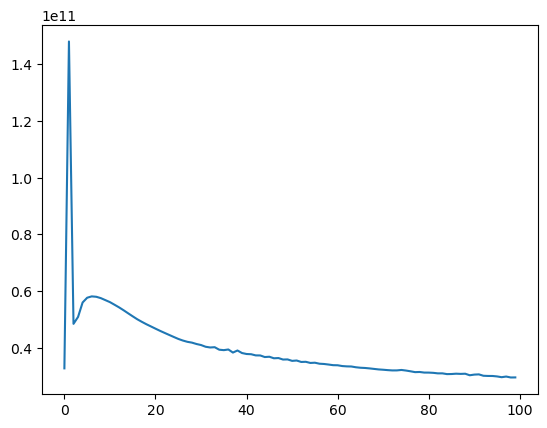

In [40]:
plt.plot(losses)

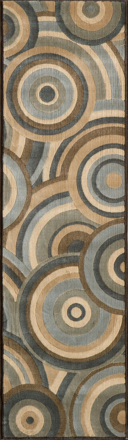

In [41]:
test_img = load_image("./image/circles.jpg", device = device)
tens2pil(test_img)

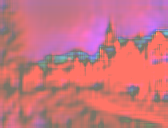

In [42]:
VGG_Decoder.eval()

f_c, _ = VGG_Encoder(content_image)
f_s, _ = VGG_Encoder(test_img)
t_ = AdaIN_fn(f_c, f_s)
T_c_s, _ = VGG_Decoder(t_)

tens2pil(T_c_s)